In [1]:
import os

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import losses, metrics, optimizers

In [3]:
BATCH_SIZE = 8
ITERATIONS = 250

### Data Preparation

In [5]:
def preprocess(image, label):
    return tf.cast(image, dtype=tf.float32)/255, label

train_data = tfds.load("stl10", split="train", as_supervised=True, shuffle_files=False, data_dir="./data")
train_data = train_data.map(preprocess).batch(BATCH_SIZE)

label_map = ['plane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'primate', 'boat', 'truck']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling data/stl10/1.0.0.incomplete9ICJKC/stl10-train.tfrecord*...:   0%|          | 0/5000 [00:00<?, ? exam…

Generating test examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling data/stl10/1.0.0.incomplete9ICJKC/stl10-test.tfrecord*...:   0%|          | 0/8000 [00:00<?, ? examp…

Generating unlabelled examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling data/stl10/1.0.0.incomplete9ICJKC/stl10-unlabelled.tfrecord*...:   0%|          | 0/100000 [00:00<?,…

Dataset stl10 downloaded and prepared to ./data/stl10/1.0.0. Subsequent calls will reuse this data.


In [7]:
from google.colab import drive
drive.mount('/content/drive')
classifier = tf.saved_model.load("drive/MyDrive/Test/LIG/checkpoints/classifier/")

Mounted at /content/drive


## DeepFool Attack

In [8]:
def compute_w_and_f(model, images, labels, num_classes=10):
    """
    Class 마다의 w, f를 계산

    Arguments:
    ----------
    - model: 분류기
    - images: (N, H, W, C) 변형할 이미지
    - labels: (N, num_classes) 실제 라벨
    - num_classes

    Returns:
    --------
    - w
    - f
    """

    N = len(images)
    images.trainable = True
    ps_for_labels = []
    ps_list_per_class = []
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(images)
        logits, ps = model(images) # logits, 확률값 리턴

        ps_for_labels = [ps[i, labels[i]] for i in range(N)]
        ps_list_per_class = [ps[:, c] for c in range(num_classes)]

    ps_for_labels = tf.stack(ps_for_labels, axis=0)
    ps_for_labels = tf.expand_dims(ps_for_labels, axis=-1)
    f = ps - ps_for_labels

    gradients_list = []

    # class별로 f 미분
    for c in range(num_classes):
        gradients = tape.gradient(ps_list_per_class[c], [images])[0]
        gradients_list.append(gradients)

    gradients = tf.stack(gradients_list, axis=1)
    gradients_for_labels = [gradients[i, labels[i]] for i in range(N)]
    gradients_for_labels = tf.stack(gradients_for_labels, axis=0)
    gradients_for_labels = tf.expand_dims(gradients_for_labels, axis=1)
    w = gradients - gradients_for_labels

    return w, f


def predict(model, image):
    pred = model(image)[0]
    pred = tf.argmax(pred, axis=-1)
    return pred


def deepfool(model, images, labels):
    N = len(images)
    x = images

    while True:
        w, f = compute_w_and_f(model, x, labels)
        w_norm_square = tf.reduce_sum(w**2, axis=(2, 3, 4))
        w_norm = tf.sqrt(w_norm_square)

        # target class 선택
        l = tf.abs(f) / w_norm
        l = l.numpy()
        for i in range(N):
            l[i, labels[i]] = 9999
        l = np.argmin(l, axis=-1)
        
        # perturbation 계산
        r = [(tf.abs(f[i, l[i]]) / w_norm_square[i, l[i]]) * w[i, l[i]] for i in range(N)]
        r = tf.stack(r, axis=0)
        
        # 라벨이 바뀌었는지에 대한 마스크: True면 안바뀐것을, False 면 바뀌었다는 것을 의미
        pred = predict(model, x)
        mask = labels.numpy() == pred.numpy()

        if mask.sum() == 0: break # 공격 다 했으면 리턴

        # 이미 공격 성공한 이미지는 업데이트안함
        x = [x[i] + r[i] for i in range(N) if mask[i] == True]

        # stacking & clipping
        x = tf.stack(x, axis=0)
        x = tf.clip_by_value(x, 0, 1)

    return x

True label / prediction


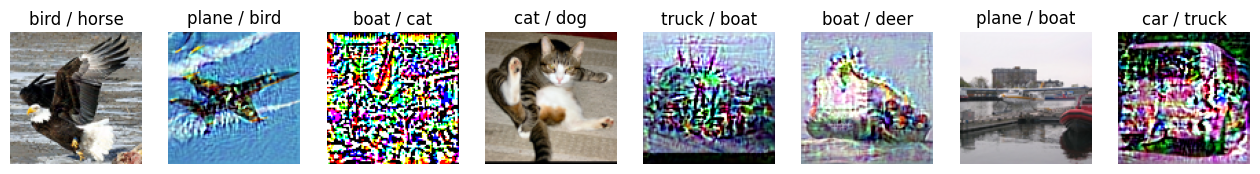

In [9]:
images, labels = next(iter(train_data))
image_fake = deepfool(classifier, images, labels)
pred = predict(classifier, image_fake)

print("True label / prediction")
plt.figure(figsize=(16, 3))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(image_fake.numpy()[i])
    plt.axis("off")
    plt.title(f"{label_map[labels.numpy()[i]]} / {label_map[pred.numpy()[i]]}")

plt.show()

# Adversarial Robustness

In [10]:
def compute_robustness(classifier, images, labels):
    N = len(images)
    
    w, f = compute_w_and_f(classifier, images, labels)
    w_norm_square = tf.reduce_sum(w**2, axis=(2, 3, 4))
    w_norm = tf.sqrt(w_norm_square)

    # target class 선택
    l = tf.abs(f) / w_norm
    l = l.numpy()
    for i in range(N):
        l[i, labels[i]] = 9999
    l = np.argmin(l, axis=-1)
    
    # perturbation 계산
    r = [(tf.abs(f[i, l[i]]) / w_norm_square[i, l[i]]) * w[i, l[i]] for i in range(N)]
    r = tf.stack(r, axis=0)
    r_norm_square = tf.reduce_sum(r**2, axis=(1, 2, 3))
    r_norm = r_norm_square ** 0.5

    x_norm_square = tf.reduce_sum(images**2, axis=(1, 2, 3))
    x_norm = x_norm_square ** 0.5

    r_norm_valid = r_norm[~tf.math.is_nan(r_norm) & ~tf.math.is_nan(x_norm)]
    x_norm_valid = x_norm[~tf.math.is_nan(r_norm) & ~tf.math.is_nan(x_norm)]

    rho = tf.reduce_mean(r_norm_valid / x_norm_valid)
    return rho

In [11]:
rho = compute_robustness(classifier, images, labels)
print("Robustness before adversarial training:", rho.numpy())

Robustness before adversarial training: 5.678122


In [15]:
def train_step(model, criterion, optimizer, images, labels):
    with tf.GradientTape() as tape:
        logits, ps = model(images)
        loss = criterion(labels, ps)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, logits, ps


def adversarial_training(classifier, images, labels):
    optimizer = optimizers.Adam(learning_rate=1e-5)
    criterion = losses.SparseCategoricalCrossentropy()
    train_loss_obj = metrics.SparseCategoricalCrossentropy()

    for e in range(3):
        loss, logits, ps = train_step(classifier, criterion, optimizer, images, labels)
        train_loss_obj.update_state(labels, ps)

        train_loss = train_loss_obj.result()

        train_loss_obj.reset_states()
        
        print(f"Epochs {e + 1}/{3}")
        print(f"Train loss: {train_loss:.6f}")

    # tf.saved_model.save(classifier, "./checkpoints/classifier_adv_trained")
    return classifier

In [16]:
image_batch = tf.concat([images, image_fake], axis=0)
label_batch = tf.concat([labels, labels], axis=0)

adversarial_training(classifier, image_batch, label_batch)

Epochs 1/3
Train loss: 0.455668
Epochs 2/3
Train loss: 0.248073
Epochs 3/3
Train loss: 0.126672


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f328810b400>

In [17]:
rho = compute_robustness(classifier, images, labels)
print("Robustness after adversarial training:", rho.numpy())

Robustness after adversarial training: 14.896075
